In [31]:
### IMPORT SCIENTIFIC LIBRARIES ###
import numpy as np
import pandas as pd
from scipy import sparse
from scipy.optimize import curve_fit
import importlib

import matplotlib.pyplot as plt
#import seaborn as sns
plt.rcParams['font.size'], plt.rcParams['axes.labelsize'] = 14, 18
#%matplotlib widget

from tqdm import tqdm
import io, sys
from contextlib import redirect_stdout, redirect_stderr

import os

import h5py
import hdf5plugin

import sys
sys.path.append('./XPCS_library/')

import ID10_tools as ID10
from ID10_tools import Nx, Ny, Npx
importlib.reload(ID10)
ID10.set_version('v2')

import XPCS_tools as XPCS
from XPCS_tools import E2lambda, lambda2E, theta2Q, Q2theta, decorelation_f
importlib.reload(XPCS)
XPCS.set_beamline('ID10')

import COSMICRAY_tools as COSMIC
importlib.reload(COSMIC)
COSMIC.set_beamline('ID10')

# RAW FOLDER PATH
raw_folder = '../RAW_DATA/'
masks_folder = '../masks/'
fit_outs_folder = './data/fit_outs/'
Idts_folder = './data/Idts/'
g2_folder = './data/g2/'

# EXPERIMENTAL VARIABLES
XPCS.set_expvar(1350, 1350, 7)
ID10.Nfmax_dense_file = 2000
ID10.Nfmax_sparse_file = 5000

## Load masks

In [32]:
e4m_htmask = np.load(masks_folder+'e4m_htmask_copper_foil_30um_1_1'+'.npy')
e4m_mask = np.load(masks_folder+'e4m_mask'+'.npy')
#bs_mask = np.load(masks_folder+'bs_mask_copper_foil_30um'+'.npy')  # beam-stop mask

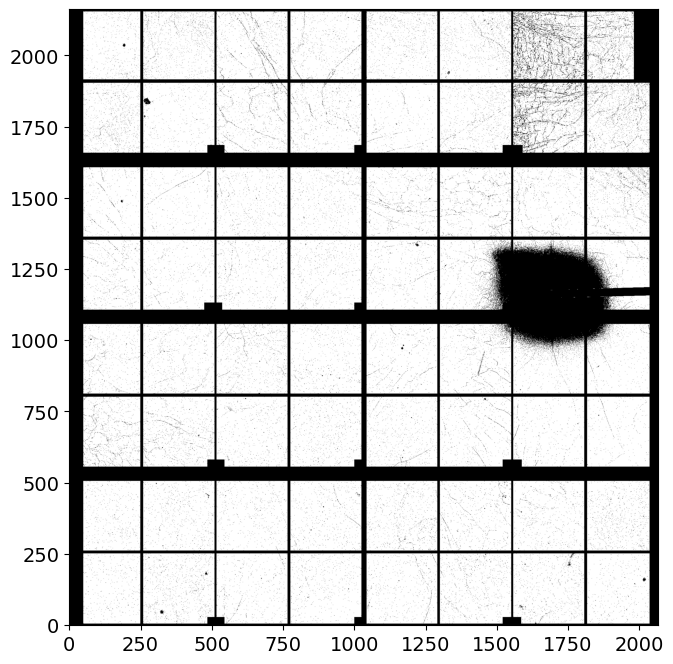

In [33]:
plt.figure(figsize=(8, 8))
plt.imshow((e4m_mask*e4m_htmask).reshape(Nx,Ny), cmap='gray', origin='lower')

### BS mask and Q definition
Using a random scan in GeO2_6, because we are not changing the measurement configuration

#### Beamstop mask

In [34]:
#######################################
sample_name = 'GeO2_6'
Ndataset = 1
Nscan =12
Nfi, Nff = 0, 1000
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']
Q = round(XPCS.theta2Q(Ei,  theta),2)

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

#############################
command = mtimescan 0.02 1 220000
Ei = 9.699998837562536
itime = 0.0201
theta = 1.7500000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/1 loops)
Done!
Concatenating vectors ...
Done!
	 | Sparse array loaded from ../RAW_DATA/GeO2_6/GeO2_6_0001/scan0012/
	 | Shape:       (1000, 4471016)
	 | Sparsity:     3.8e-03
	 | Memory usage (scipy.csr_array): 0.192 GB (np.array usage: 16.656 GB)


################################################################################
Maximum count in the hull run -> 4689
# of pixels above Ith_high treshold ->  75 pixels (of 4471016 => 0.0 %)
################################################################################



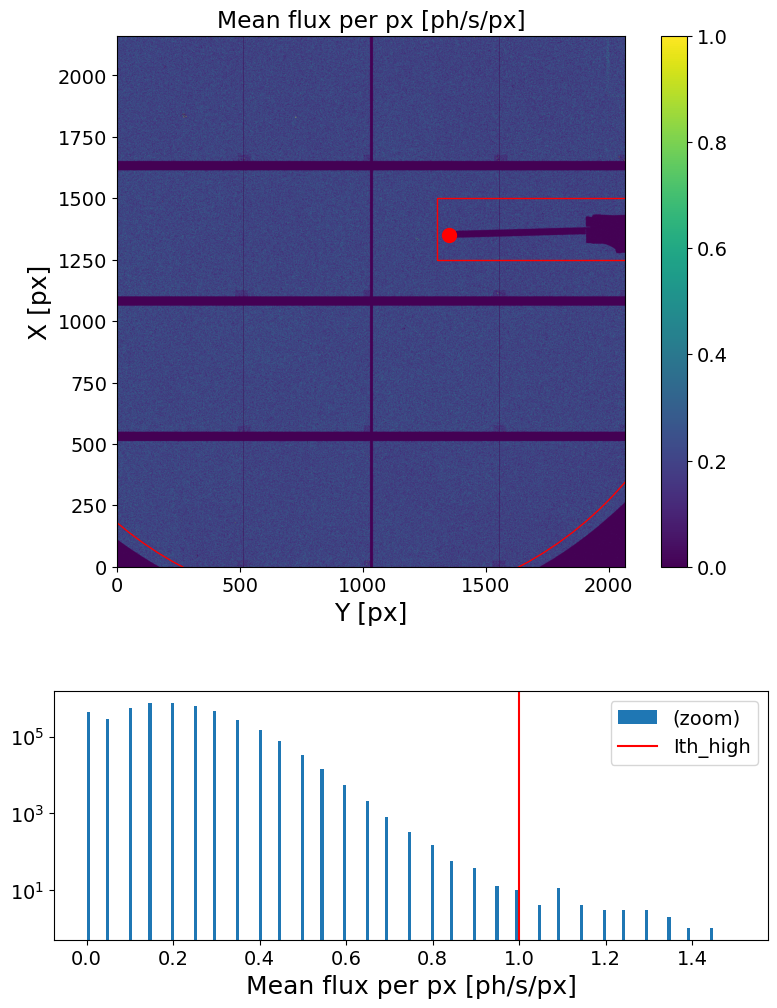

In [35]:
geom = [{'geom':'Rectangle', 'x0':1250, 'y0':1300, 'xl':250, 'yl':1950, 'inside':False},
        {'geom':'Circle', 'Cx':1300, 'Cy':950, 'r':1470, 'inside':True}, 
        ]
XPCS.gen_plots4mask(e4m_data, itime, Ith_high=1, Nff=10000, mask_geom=geom,)

#################################################
Masked area =  93.74594052000708 %
#################################################



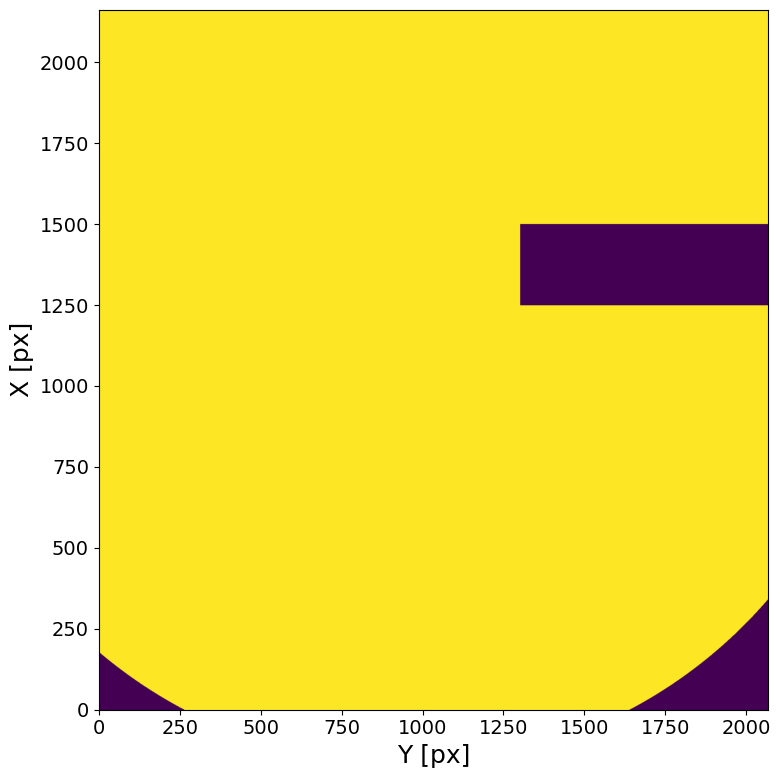

In [36]:
bs_mask = XPCS.gen_mask(e4m_data, itime, e4m_mask=None, mask_geom=geom)

#### Q mask

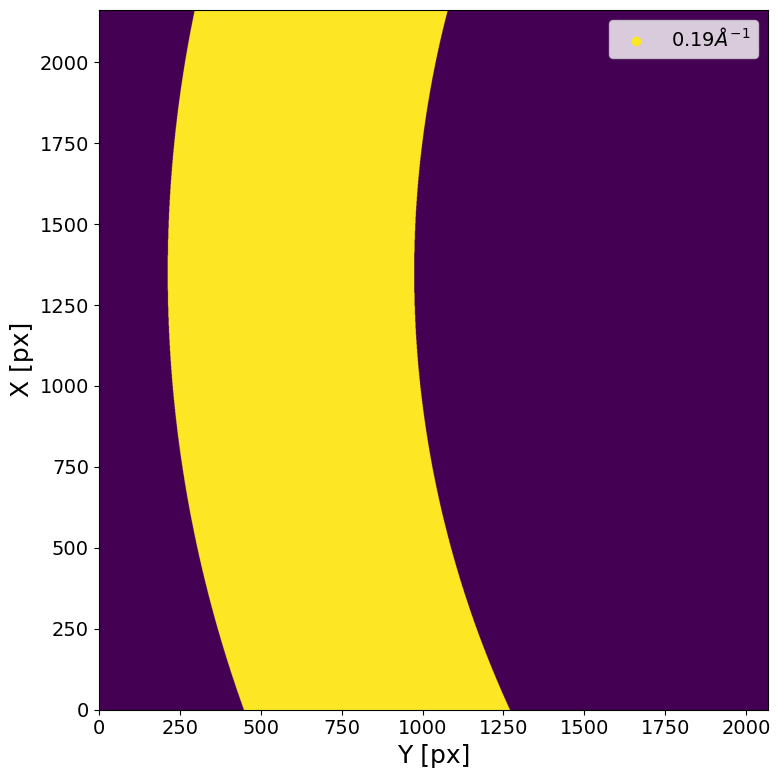

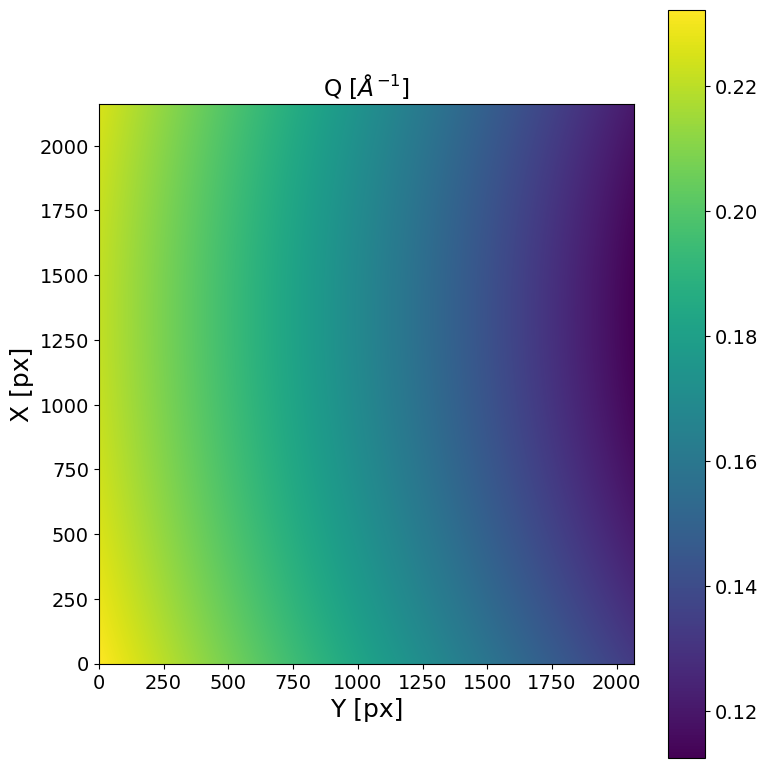

In [37]:
Qmask = XPCS.gen_Qmask(Ei, theta, .19, .02, Qmap_plot=True)

## XPCS scan (Ei =  9.7 keV, T = 30C Q =  0.19 Å, 20 min @ 1ms (1_200_000 fm)) (Ta2O5, dataset 1, scan 7)

In [38]:
#######################################
sample_name = 'Ta2O5'
Ndataset = 1
Nscan = 7
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 1200192
Ei = 8.669998877636312
itime = 0.0011
theta = 2.0000000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/241 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/241 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  1300925 pixels (of 4471016 => 39.12 %)
################################################################################



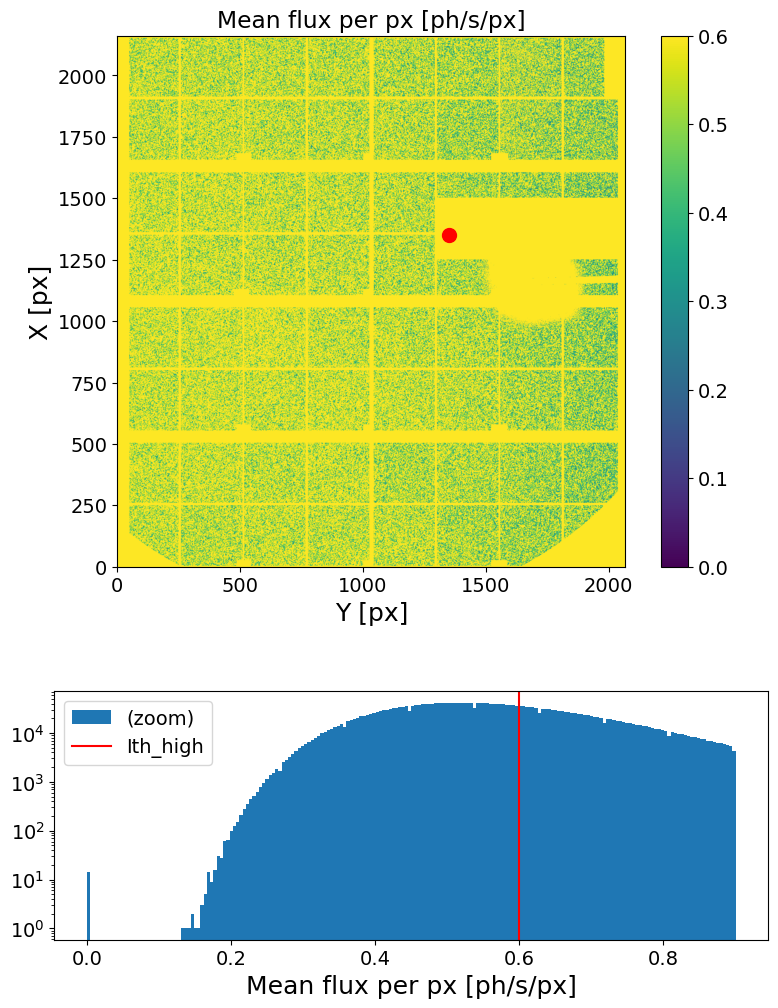

In [39]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .6, Nff=1000000, e4m_mask=mask)

### Intensity analysis

In [41]:
####################
Lbin = 1
Nstep = 1000
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

[  0.70706478 566.30279328   0.90972659] [3.18644505e-03 7.99935958e+00 3.77590633e-03]


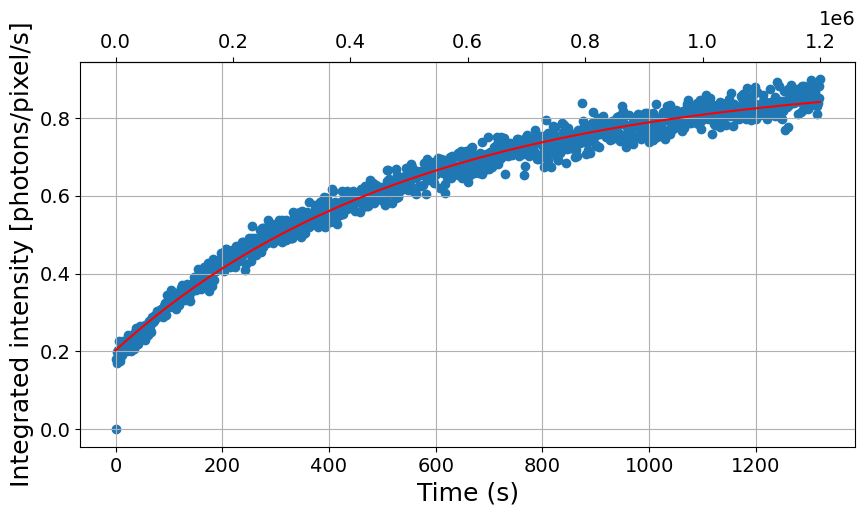

In [42]:
def exp_fit(t, A, B, C):
    return -A*np.exp(-t/B) + C
popt,pcov = curve_fit(exp_fit,t_It,It, p0=[1, 1000, 0.2], bounds=(0, [np.inf, np.inf, np.inf]), maxfev=10000)

print(popt, np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.plot(t_It, exp_fit(t_It, *popt), 'r',zorder=10)
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
#plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [43]:
###################
Nfi = 100
Nff = 200000
Lbin = 100
Nbunch = 1
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Nfi == None: Nfi = 0
if Nff == None: Nff = e4m_data.shape[0]
if Lbin == None: Lbin = 1


Lbunch = (Nff-Nfi)//Nbunch

t, g2, t_mt, g2_mt = {}, {}, {}, {}

for i in range(Nbunch):
    
    print('Computing G2t for bunch', i+1, '(Nfi =', Nfi+i*Lbunch, ', Nff =', Nfi+(i+1)*Lbunch, ') ...')
    G2t = XPCS.get_G2t(e4m_data, mask, Nfi=Nfi+i*Lbunch, Nff=Nfi+(i+1)*Lbunch, Lbin=Lbin)

    t_bunch = round(itime*Lbunch*Nbunch*(i+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, G2t, cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])   



Computing G2t for bunch 1 (Nfi = 100 , Nff = 200000 ) ...
Loading frames ...
Done! (elapsed time = 6.28 s)
Binning frames (Lbin = 100, using MKL library) ...
Done! (elapsed time = 6.99 s)
	 | 1999 frames X 4471016 pixels
	 | sparsity = 3.12e-02
	 | memory usage (sparse.csr_array @ float64) = 3.119 GB
Masking data ...
Done! (elapsed time = 4.39 s)
	 | 1999 frames X 1427140 pixels
	 | sparsity = 3.49e-02
	 | memory usage (sparse.csr_array @ float64) = 1.113 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 6.83 s)
	 | 1999 X 1999 squared matrix
	 | memory usage (np.array @ float64) = 0.03 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.07 s)

Computing g2...
Done! (elapsed time = 0.01 s)



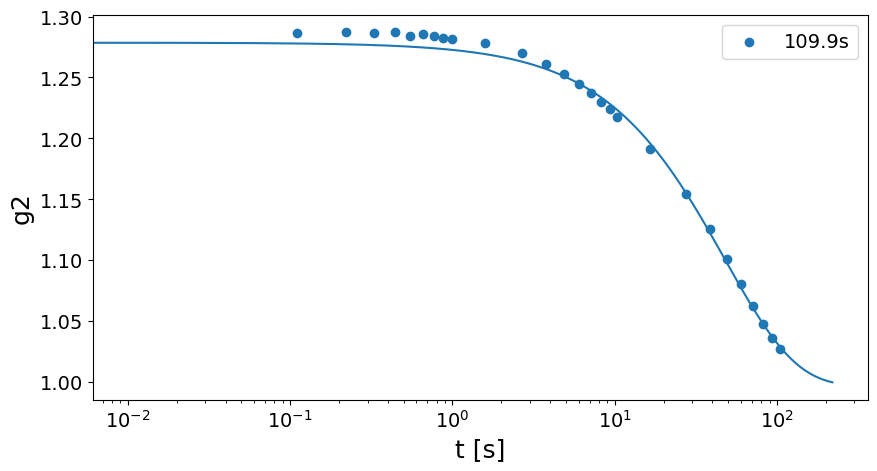

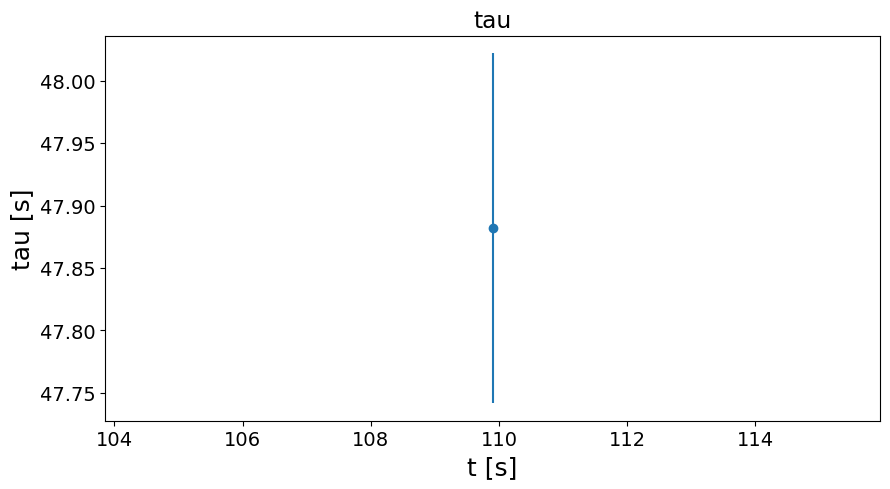

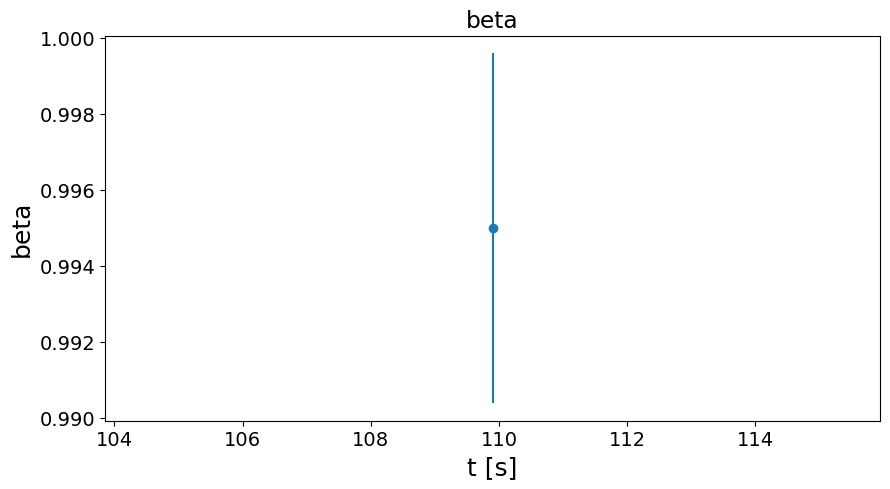

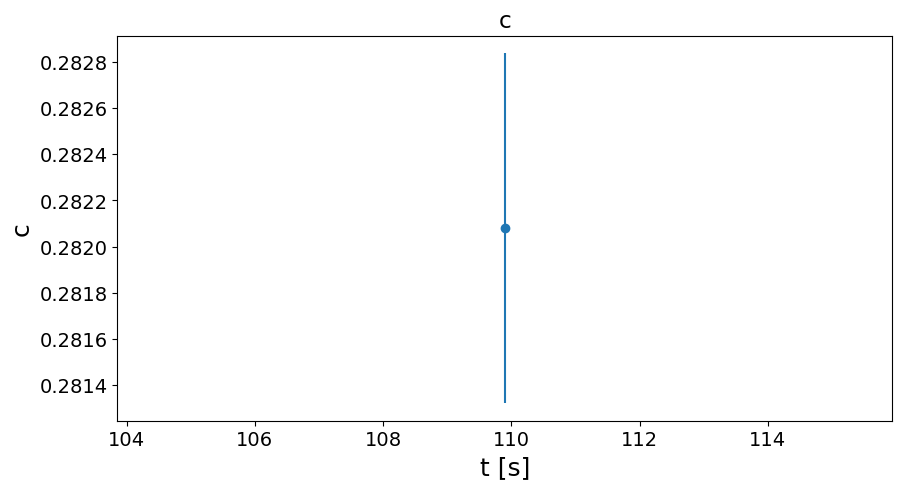

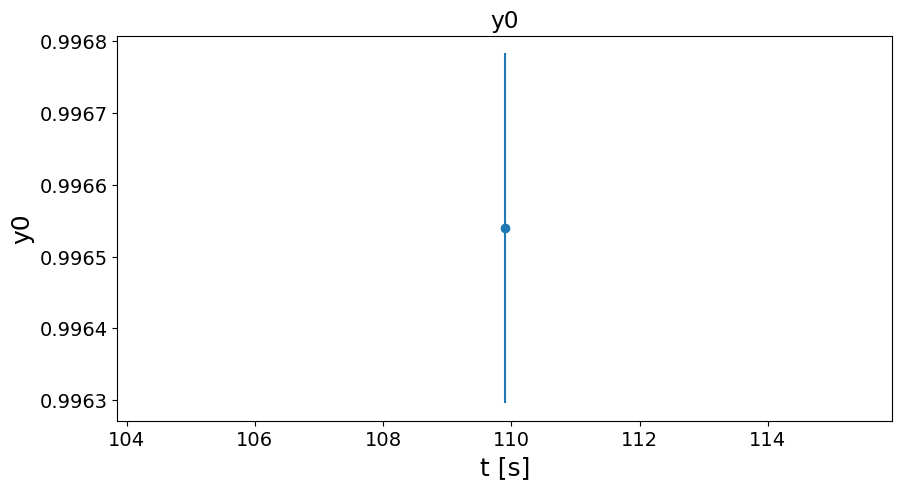

In [44]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .02, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]))
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.legend()
plt.show()



plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.show()  

## XPCS scan (Ei =  9.7 keV, T = 30C Q =  0.19 Å, 25 min @ 1ms (1_500_000 fm)) (Ta2O5, dataset 1, scan 8)

In [8]:
#######################################
sample_name = 'Ta2O5'
Ndataset = 1
Nscan = 8
Nfi, Nff =  None, 1_500_000
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 8.669998877636312
itime = 0.0011
theta = 2.0000000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/301 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/301 loop

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  38003 pixels (of 4471016 => 1.14 %)
################################################################################



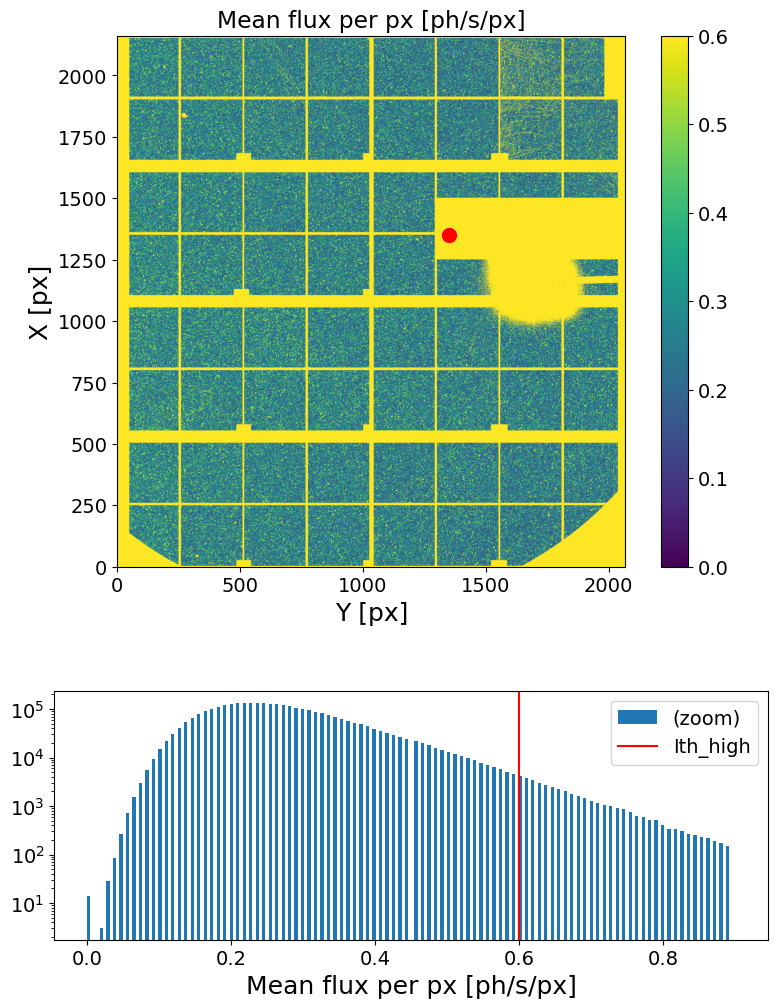

In [9]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .6, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [10]:
####################
Lbin = 1
Nstep = 10
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

[7.63941738e-01 7.85958733e+02 1.02393641e+00] [4.14795584e-04 1.27146425e+00 5.05096433e-04]


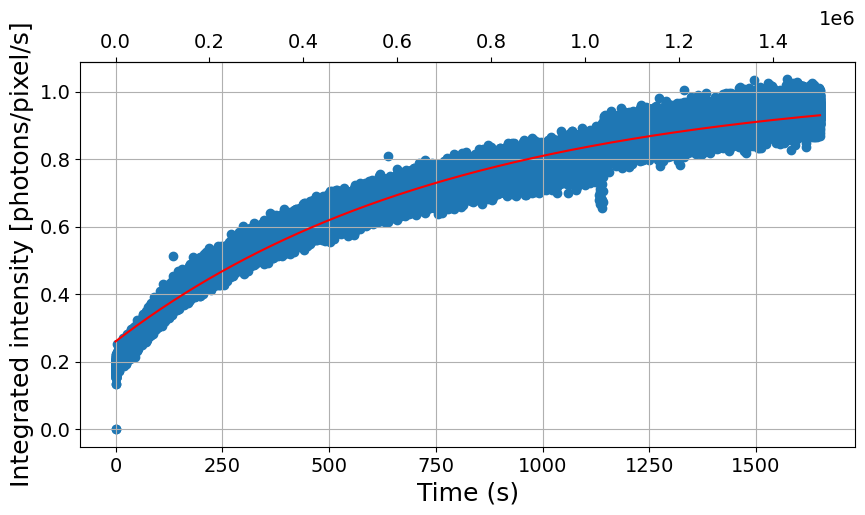

In [11]:
def exp_fit(t, A, B, C):
    return -A*np.exp(-t/B) + C
popt,pcov = curve_fit(exp_fit,t_It,It, p0=[1, 1000, 0.2], bounds=(0, [np.inf, np.inf, np.inf]), maxfev=10000)

print(popt, np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.plot(t_It, exp_fit(t_It, *popt), 'r',zorder=10)
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
#plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [12]:
###################
Nfi = 1
Nff = None
Lbin = 50
Nbunch = 5
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Nfi == None: Nfi = 0
if Nff == None: Nff = e4m_data.shape[0]
if Lbin == None: Lbin = 1


Lbunch = (Nff-Nfi)//Nbunch

t, g2, t_mt, g2_mt = {}, {}, {}, {}

for i in range(Nbunch):
    
    print('Computing G2t for bunch', i+1, '(Nfi =', Nfi+i*Lbunch, ', Nff =', Nfi+(i+1)*Lbunch, ') ...')
    G2t = XPCS.get_G2t(e4m_data, mask, Nfi=Nfi+i*Lbunch, Nff=Nfi+(i+1)*Lbunch, Lbin=Lbin)

    t_bunch = round(itime*Lbunch*Nbunch*(i+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, G2t, cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])   



Computing G2t for bunch 1 (Nfi = 1 , Nff = 300000 ) ...
Loading frames ...
Done! (elapsed time = 8.59 s)
Binning frames (Lbin = 50, using MKL library) ...
Done! (elapsed time = 14.08 s)
	 | 5999 frames X 4471016 pixels
	 | sparsity = 1.95e-02
	 | memory usage (sparse.csr_array @ float64) = 5.831 GB
Masking data ...
Done! (elapsed time = 4.78 s)
	 | 5999 frames X 1427140 pixels
	 | sparsity = 2.18e-02
	 | memory usage (sparse.csr_array @ float64) = 2.089 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 12.57 s)
	 | 5999 X 5999 squared matrix
	 | memory usage (np.array @ float64) = 0.268 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.09 s)

Computing g2...
Done! (elapsed time = 0.06 s)

Computing G2t for bunch 2 (Nfi = 300000 , Nff = 599999 ) ...
Loading frames ...
Done! (elapsed time = 9.71 s)
Binning frames (Lbin = 50, using MKL library) ...
Done! (elapsed time = 22.98 s)
	 | 5999 frames X 4471016 pixels
	 | sparsity = 2.96e-02
	 | memory usage (spar

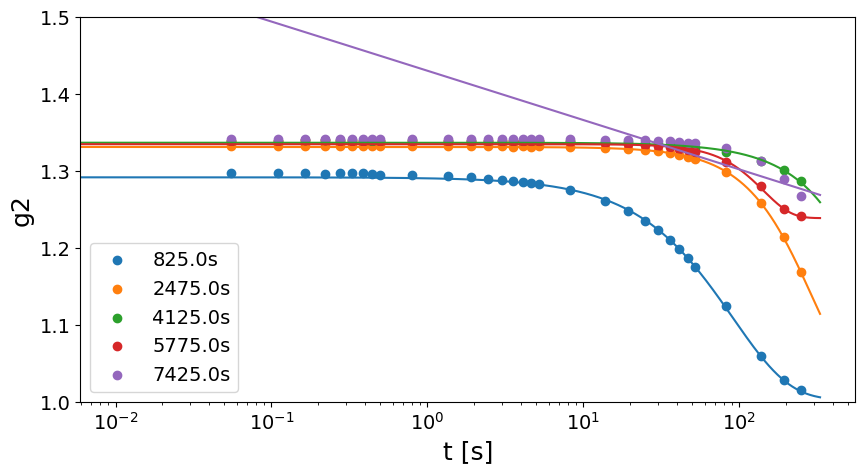

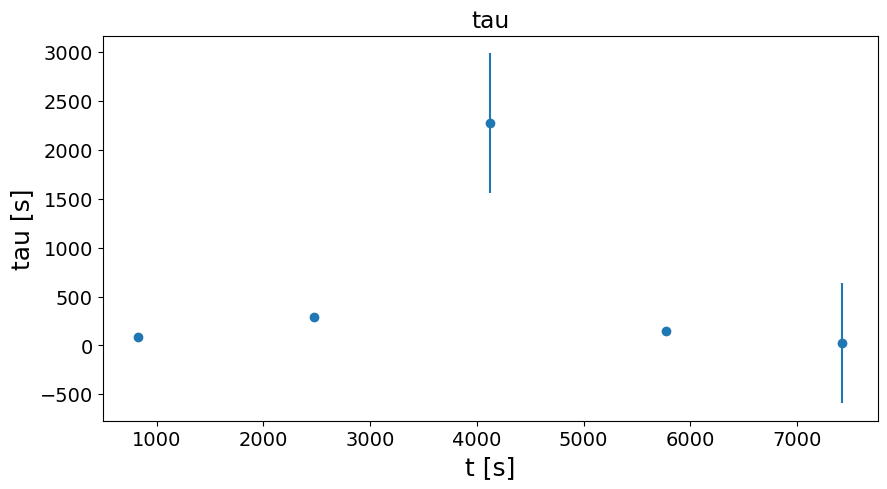

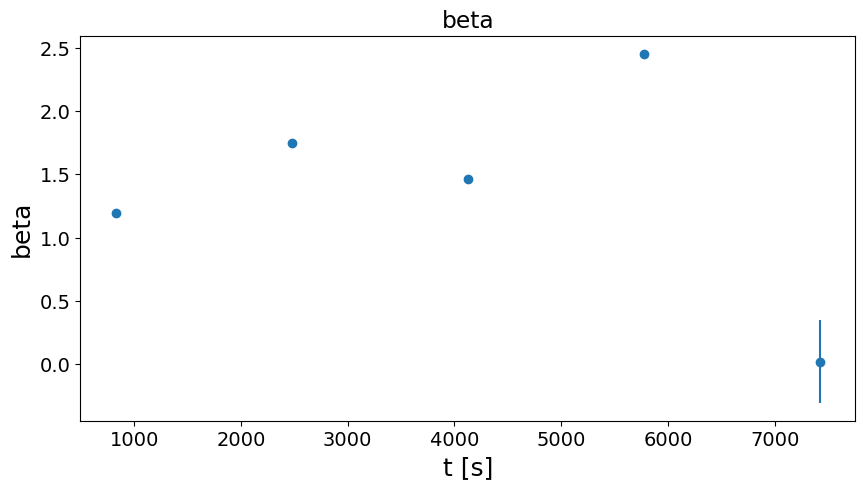

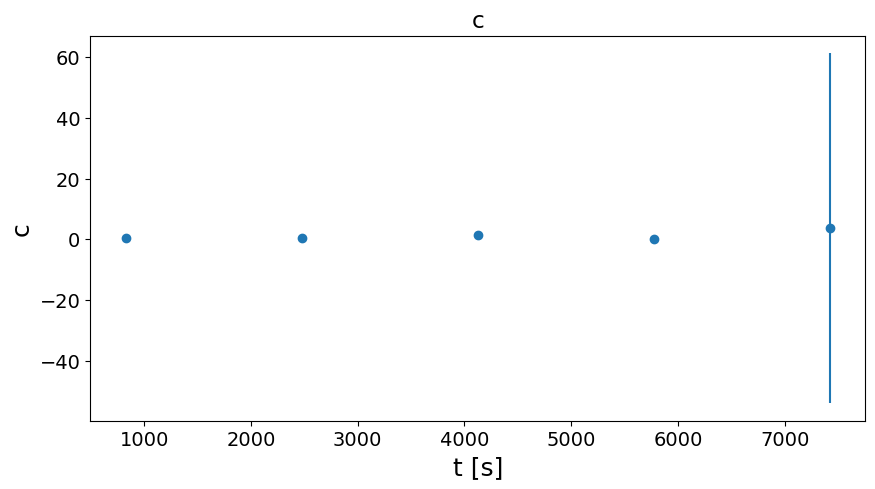

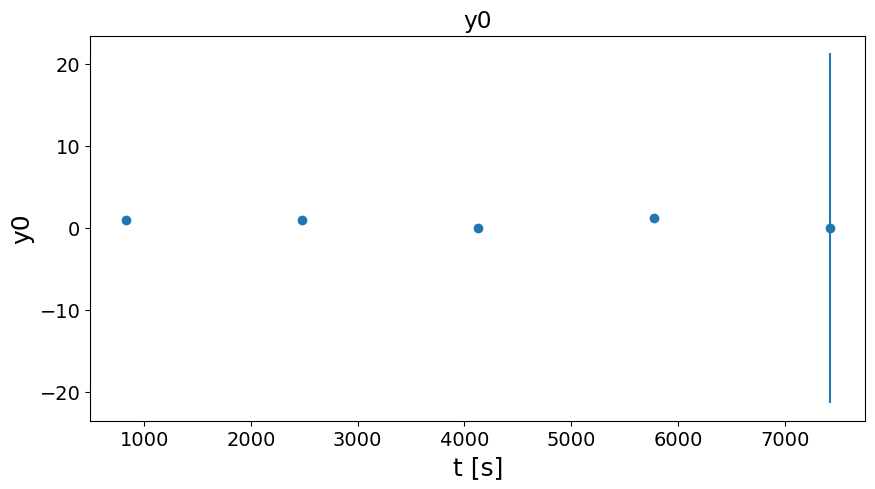

In [16]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .2, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]),maxfev=100_000)
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1,1.5)
plt.legend()
plt.show()



plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.show()  

## XPCS scan (Ei =  9.7 keV, T = 30C Q =  0.19 Å, 25 min @ 1ms (1_500_000 fm)) (Ta2O5, dataset 1, scan 10)

In [25]:
#######################################
sample_name = 'Ta2O5'
Ndataset = 1
Nscan = 20
Nfi, Nff =  None, None
#######################################

scan = ID10.load_scan(raw_folder, sample_name, Ndataset, Nscan)
Ei = scan['monoe']
itime = scan['fast_timer_period'][0]
theta = scan['delcoup']

print('#############################')
print('command =', scan['command'])
print('Ei =', Ei)
print('itime =', itime)
print('theta =', theta)
print('Q =', Q)
print('#############################\n')

e4m_data = ID10.load_sparse_e4m(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )
#e4m_data = ID10.load_dense_e4m_new(raw_folder, sample_name, Ndataset, Nscan, Nfi, Nff,  n_jobs=1, )

e4m_data = COSMIC.fast_gamma_filter(e4m_data, Imaxth_high=5)

#############################
command = mtimescan 0.001 1 3599664
Ei = 8.669998877636312
itime = 0.0011
theta = 2.0000000000000004
Q = 0.15
#############################

Loading sparse array ...
	 -> loading file eiger4m_v2_sparse_frame_0_00000.h5 (1/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00001.h5 (2/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00002.h5 (3/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00003.h5 (4/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00004.h5 (5/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00005.h5 (6/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00006.h5 (7/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00007.h5 (8/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00008.h5 (9/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00009.h5 (10/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00010.h5 (11/22 loops)
	 -> loading file eiger4m_v2_sparse_frame_0_00011.h5 (12/22 loops)
	 -> load

### Flux check

################################################################################
Maximum count in the hull run -> 5
# of pixels above Ith_high treshold ->  155482 pixels (of 4471016 => 4.68 %)
################################################################################



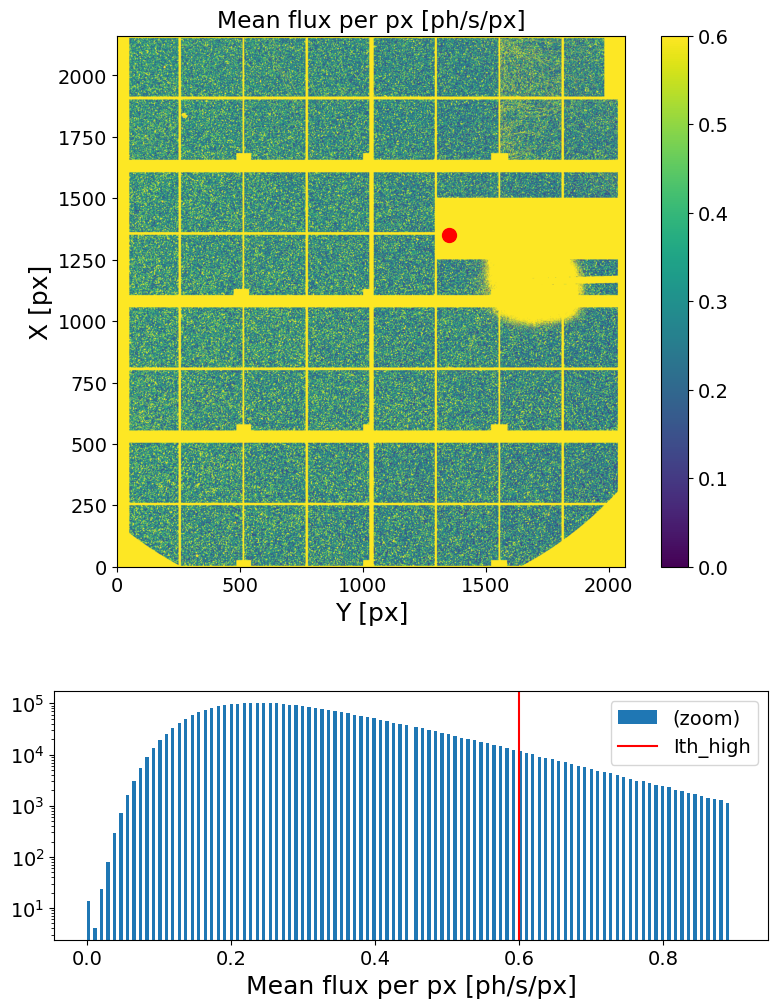

In [26]:
#############################################
mask = e4m_mask * e4m_htmask * bs_mask
#############################################

XPCS.gen_plots4mask(e4m_data, itime, Ith_high= .6, Nff=100_000, e4m_mask=mask)

### Intensity analysis

In [27]:
####################
Lbin = 1
Nstep = 1
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
####################

t_It, It = XPCS.get_It(e4m_data, itime, mask=mask, Lbin=Lbin, Nstep=Nstep)
np.savez(Idts_folder+'Idt_'+sample_name+'_'+str(Ndataset).zfill(4)+'_'+str(Nscan).zfill(4), t_It=t_It, It=It)

[  0.17890062 107.25700976   0.43582979] [9.58246447e-04 1.05229174e+00 1.05344262e-03]


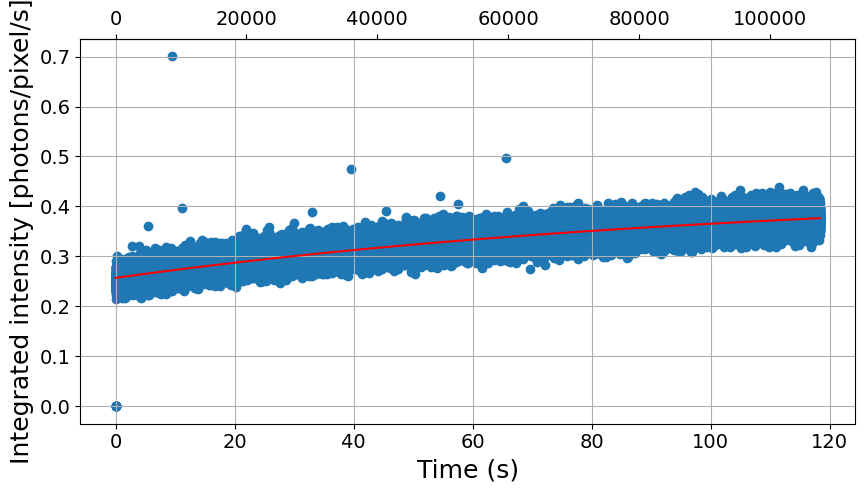

In [28]:
def exp_fit(t, A, B, C):
    return -A*np.exp(-t/B) + C
popt,pcov = curve_fit(exp_fit,t_It,It, p0=[1, 1000, 0.2], bounds=(0, [np.inf, np.inf, np.inf]), maxfev=10000)

print(popt, np.sqrt(np.diag(pcov)))
plt.figure(figsize=(10,5))
plt.scatter(t_It, It, label='It')
plt.plot(t_It, exp_fit(t_It, *popt), 'r',zorder=10)
plt.xlabel('Time (s)')
plt.ylabel('Integrated intensity [photons/pixel/s]')
#plt.xscale('log')
#plt.xlim(1e-2, 1)
plt.gca().secondary_xaxis('top', functions=(lambda x: x/itime, lambda x: x*itime))
plt.grid()

### Correlation

In [29]:
###################
Nfi = 1
Nff = None
Lbin = 10
Nbunch = 2
mask = e4m_mask * e4m_htmask * bs_mask * Qmask
###################
if Nfi == None: Nfi = 0
if Nff == None: Nff = e4m_data.shape[0]
if Lbin == None: Lbin = 1


Lbunch = (Nff-Nfi)//Nbunch

t, g2, t_mt, g2_mt = {}, {}, {}, {}

for i in range(Nbunch):
    
    print('Computing G2t for bunch', i+1, '(Nfi =', Nfi+i*Lbunch, ', Nff =', Nfi+(i+1)*Lbunch, ') ...')
    G2t = XPCS.get_G2t(e4m_data, mask, Nfi=Nfi+i*Lbunch, Nff=Nfi+(i+1)*Lbunch, Lbin=Lbin)

    t_bunch = round(itime*Lbunch*Nbunch*(i+1/2),1)

    t[t_bunch], g2[t_bunch] = XPCS.get_g2(itime*Lbin, G2t, cython=False)
    t_mt[t_bunch], g2_mt[t_bunch] = XPCS.get_g2_mt(itime*Lbin, g2[t_bunch])   



Computing G2t for bunch 1 (Nfi = 1 , Nff = 53810 ) ...
Loading frames ...
Done! (elapsed time = 1.39 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 2.72 s)
	 | 5380 frames X 4471016 pixels
	 | sparsity = 2.94e-03
	 | memory usage (sparse.csr_array @ float64) = 0.79 GB
Masking data ...
Done! (elapsed time = 0.74 s)
	 | 5380 frames X 1427140 pixels
	 | sparsity = 3.28e-03
	 | memory usage (sparse.csr_array @ float64) = 0.281 GB
Computing G2t (using MKL library)...
Done! (elapsed time = 1.89 s)
	 | 5380 X 5380 squared matrix
	 | memory usage (np.array @ float64) = 0.216 GB
Normalizing G2t (using NumExpr library)...
Done! (elapsed time = 0.19 s)

Computing g2...
Done! (elapsed time = 0.21 s)

Computing G2t for bunch 2 (Nfi = 53810 , Nff = 107619 ) ...
Loading frames ...
Done! (elapsed time = 1.69 s)
Binning frames (Lbin = 10, using MKL library) ...
Done! (elapsed time = 2.76 s)
	 | 5380 frames X 4471016 pixels
	 | sparsity = 3.48e-03
	 | memory usage (sparse.csr

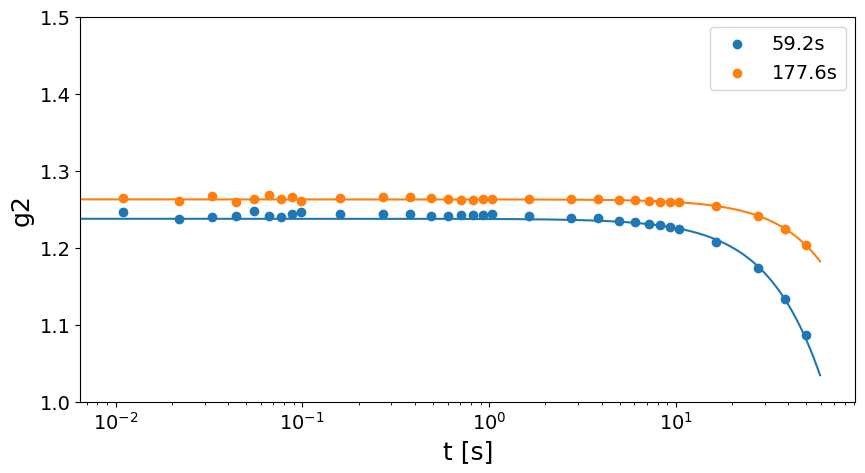

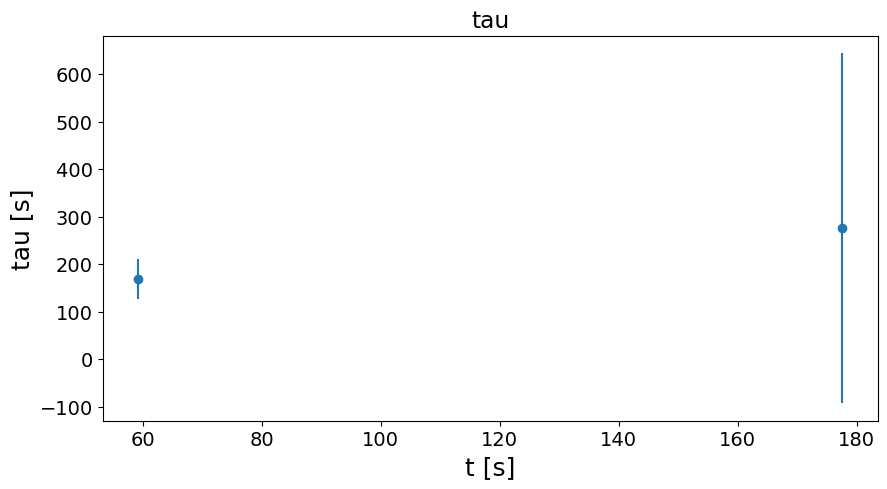

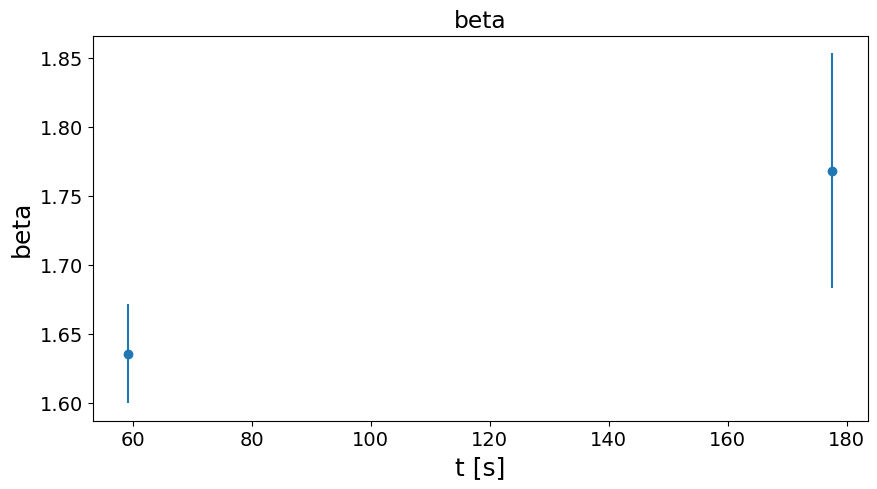

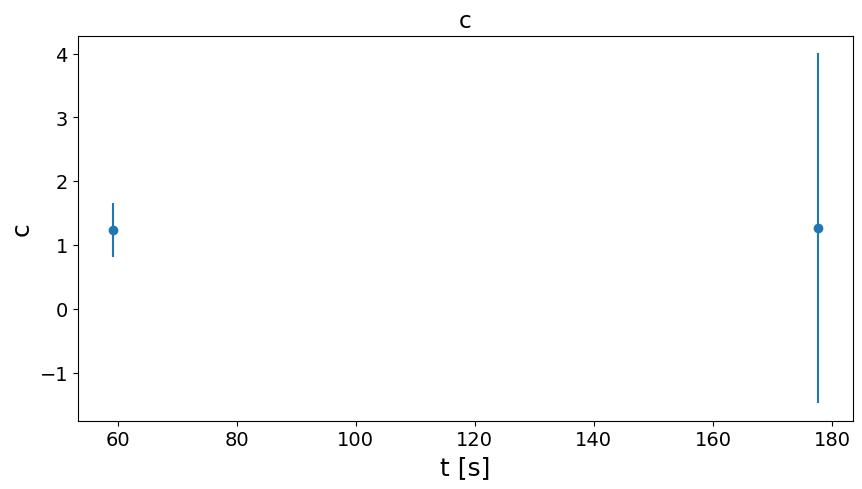

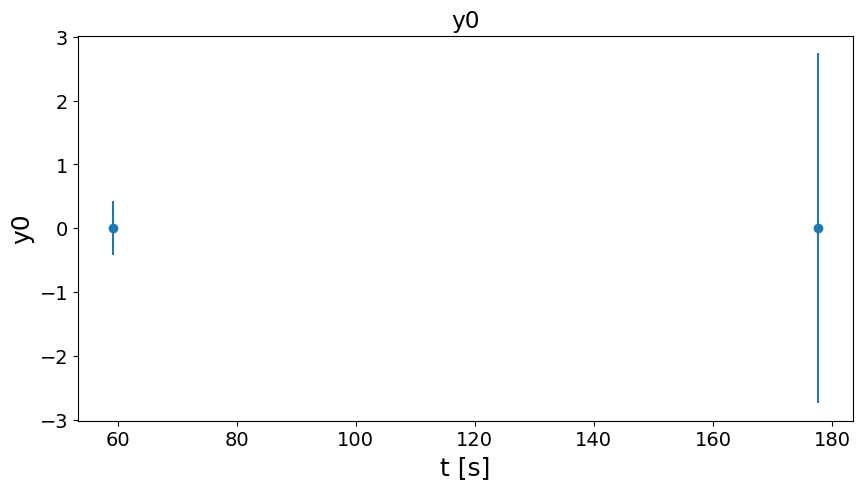

In [30]:
##################
t1_fit = 0
t2_fit = 1e8
##################
 
plt.figure(figsize=(10,5))
fit_out = pd.DataFrame(columns=['tau', 'beta', 'c', 'y0', 'dtau', 'dbeta', 'dc', 'dy0'])
fit_out.index.name = 't'
for k in g2.keys():
    #plt.scatter(t[k], g2[k], s=1, label = str(k)+'s')
    plt.scatter(t_mt[k], g2_mt[k], label=str(k)+'s')

    popt, pcov = curve_fit(decorelation_f, t[k][(t1_fit<t[k])*(t[k]<t2_fit)], g2[k][(t1_fit<t[k])*(t[k]<t2_fit)], p0=[3, .7, .2, 1], bounds=([0, 0, 0, 0], [np.inf, np.inf, np.inf, np.inf]),maxfev=100_000)
    fit_out.loc[k] = [popt[0], popt[1], popt[2], popt[3], np.sqrt(pcov[0,0]), np.sqrt(pcov[1,1]), np.sqrt(pcov[2,2]), np.sqrt(pcov[3,3])]
    
    x = np.arange(np.min(t[k]), np.max(t[k]), 1e-2)
    y = decorelation_f(x, *popt)
    plt.plot(x, y,)

plt.xlabel('t [s]')
plt.ylabel('g2')
plt.xscale('log')
plt.ylim(1,1.5)
plt.legend()
plt.show()



plt.figure(figsize=(10,5))
plt.title('tau')
plt.errorbar(fit_out.index, fit_out.tau,  yerr=fit_out.dtau, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('tau [s]')
plt.show()

plt.figure(figsize=(10,5))
plt.title('beta')
plt.errorbar(fit_out.index, fit_out.beta,  yerr=fit_out.dbeta, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('beta')
plt.show()

plt.figure(figsize=(10,5))
plt.title('c')
plt.errorbar(fit_out.index, fit_out.c,  yerr=fit_out.dc, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('c')
plt.show()

plt.figure(figsize=(10,5))
plt.title('y0')
plt.errorbar(fit_out.index, fit_out.y0,  yerr=fit_out.dy0, fmt='o')
plt.xlabel('t [s]')
plt.ylabel('y0')
plt.show()  